In [1]:
!pip install pandas
!pip install pyarrow
!pip install SQLAlchemy
!pip install matplotlib seaborn

In [113]:
import pyarrow
import pandas as pd
import sqlite3
from sqlalchemy import create_engine

In [114]:
orders = pd.read_parquet("orders.parquet")

In [115]:
orders.drop_duplicates
orders.fillna(0)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9416 entries, 0 to 9415
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID заказа     9416 non-null   int64  
 1   Имя клиента   9416 non-null   object 
 2   ID Товара     9416 non-null   int64  
 3   Дата заказа   9416 non-null   object 
 4   Количество    9416 non-null   string 
 5   Цена          9416 non-null   string 
 6   Скидка (%)    9416 non-null   string 
 7   Сумма заказа  9416 non-null   float64
dtypes: float64(1), int64(2), object(2), string(3)
memory usage: 588.6+ KB


In [116]:
orders['Дата заказа'] = pd.to_datetime(orders['Дата заказа'], errors='coerce')
orders['Дата заказа_строка'] = orders['Дата заказа'].dt.strftime('%d.%m.%Y')
missing_dates = orders[orders['Дата заказа'].isna()]
print(missing_dates)


      ID заказа Имя клиента  ID Товара Дата заказа Количество      Цена  \
22           11  Клиент_102        217         NaT          5  25144.63   
137          68  Клиент_363        250         NaT          2  31013.07   
169          82  Клиент_445        459         NaT          2  35191.23   
199          97  Клиент_353         38         NaT          2  19303.98   
293         144  Клиент_269         46         NaT          1   22658.2   
...         ...         ...        ...         ...        ...       ...   
8940       4493  Клиент_498        312         NaT          2   7523.77   
9124       4578  Клиент_335        328         NaT          3  26284.88   
9144       4587  Клиент_149          5         NaT          3  43751.29   
9145       4587  Клиент_149         96         NaT          1   36023.1   
9225       4626   Клиент_80        159         NaT          4  30387.78   

     Скидка (%)  Сумма заказа Дата заказа_строка  
22            0     125723.15                NaN

In [117]:
missing_dates = orders[orders['Дата заказа'].isna()]
unique_combinations = missing_dates.groupby(['Имя клиента', 'ID Товара']).size().reset_index(name='count')
print(unique_combinations)

   Имя клиента  ID Товара  count
0     Клиент_1         68      1
1    Клиент_10        440      1
2   Клиент_102        198      1
3   Клиент_102        217      1
4    Клиент_11         60      1
..         ...        ...    ...
89   Клиент_91        209      1
90   Клиент_91        267      1
91   Клиент_94        108      1
92   Клиент_94        282      1
93   Клиент_94        488      1

[94 rows x 3 columns]


In [118]:
orders = orders.dropna(subset=['Дата заказа'])

In [119]:
orders['Цена'] = orders['Цена'].astype(float)
orders_non_numeric = orders[~orders['Количество'].str.replace(',','.').str.isnumeric()]
orders['Количество'] = pd.to_numeric(orders['Количество'], errors = 'coerce')
orders['Количество'] = orders['Количество'].astype(float)

In [120]:
orders['Скидка (%)'] = pd.to_numeric(orders['Скидка (%)'], errors='coerce')
orders['Скидка (%)'] = orders['Скидка (%)'].astype(float)
orders['Скидка (%)'] = orders['Скидка (%)'].fillna(0)

In [121]:
orders['Скидка (%)'] = orders['Скидка (%)'] / 100
orders.loc[orders['Количество'].isna(), 'Количество'] = (
    orders.loc[orders['Количество'].isna(), 'Сумма заказа'] /
    (orders.loc[orders['Количество'].isna(), 'Цена'] * (1 - orders.loc[orders['Количество'].isna(), 'Скидка (%)']))
).abs()
orders['Скидка (%)'] = orders['Скидка (%)'].round(2)

In [122]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9322 entries, 0 to 9415
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ID заказа           9322 non-null   int64         
 1   Имя клиента         9322 non-null   object        
 2   ID Товара           9322 non-null   int64         
 3   Дата заказа         9322 non-null   datetime64[ns]
 4   Количество          9322 non-null   float64       
 5   Цена                9322 non-null   float64       
 6   Скидка (%)          9322 non-null   float64       
 7   Сумма заказа        9322 non-null   float64       
 8   Дата заказа_строка  9322 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 728.3+ KB


In [123]:
print("Количество:", orders['Количество'].isna().mean())
print("Цена:", orders['Цена'].isna().mean())
print("Сумма заказа:", orders['Сумма заказа'].isna().mean())
print("Скидка (%)", orders['Скидка (%)'].isna().mean())

Количество: 0.0
Цена: 0.0
Сумма заказа: 0.0
Скидка (%) 0.0


In [124]:
orders['Дата заказа'] = pd.to_datetime(orders['Дата заказа_строка'], dayfirst=True, errors='coerce')
orders = orders.drop(columns=['Дата заказа_строка'])
orders['Дата заказа'].min(), orders['Дата заказа'].max()

(Timestamp('2023-01-01 00:00:00'), Timestamp('2025-06-30 00:00:00'))

In [125]:
orders.isna().sum()

ID заказа       0
Имя клиента     0
ID Товара       0
Дата заказа     0
Количество      0
Цена            0
Скидка (%)      0
Сумма заказа    0
dtype: int64

In [126]:
missing_rows = orders[orders.isna().any(axis=1)]
print(missing_rows)

Empty DataFrame
Columns: [ID заказа, Имя клиента, ID Товара, Дата заказа, Количество, Цена, Скидка (%), Сумма заказа]
Index: []


In [127]:
orders = orders.dropna(subset=[
    'ID заказа', 'Имя клиента', 'ID Товара',
    'Дата заказа', 'Количество', 'Цена', 'Сумма заказа']
)

In [128]:
orders.head(10)

,ID заказа,Имя клиента,ID Товара,Дата заказа,Количество,Цена,Скидка (%),Сумма заказа
0,1,Клиент_156,172,2023-01-01,4.0,49714.23,0.00,198856.92
1,2,Клиент_337,403,2023-01-01,5.0,43939.34,0.25,164772.52
2,2,Клиент_337,207,2023-01-01,4.0,11374.47,0.00,45497.88
3,2,Клиент_337,326,2023-01-01,2.0,26728.47,0.25,40092.70
4,3,Клиент_432,171,2023-01-01,1.0,2224.02,0.00,2224.02
5,4,Клиент_432,113,2023-01-01,5.0,13564.38,0.15,57648.61
6,4,Клиент_432,483,2023-01-01,4.0,30942.35,0.05,117580.93
7,4,Клиент_432,94,2023-01-01,4.0,21221.42,0.15,72152.83
8,5,Клиент_284,299,2023-01-01,5.0,48759.58,0.15,207228.22
9,5,Клиент_284,1,2023-01-01,3.0,19274.53,0.20,46258.87


In [136]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9147 entries, 0 to 9403
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID заказа     9147 non-null   int64         
 1   Имя клиента   9147 non-null   object        
 2   ID Товара     9147 non-null   int64         
 3   Дата заказа   9147 non-null   datetime64[ns]
 4   Количество    9147 non-null   float64       
 5   Цена          9147 non-null   float64       
 6   Скидка (%)    9147 non-null   int64         
 7   Сумма заказа  9147 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 643.1+ KB


In [93]:
orders.shape

(9322, 8)

In [130]:
orders['Скидка (%)'] = (orders['Скидка (%)'] * 100).round(0).astype(int)

In [131]:
orders.head(10)

,ID заказа,Имя клиента,ID Товара,Дата заказа,Количество,Цена,Скидка (%),Сумма заказа
0,1,Клиент_156,172,2023-01-01,4.0,49714.23,0,198856.92
1,2,Клиент_337,403,2023-01-01,5.0,43939.34,25,164772.52
2,2,Клиент_337,207,2023-01-01,4.0,11374.47,0,45497.88
3,2,Клиент_337,326,2023-01-01,2.0,26728.47,25,40092.70
4,3,Клиент_432,171,2023-01-01,1.0,2224.02,0,2224.02
5,4,Клиент_432,113,2023-01-01,5.0,13564.38,15,57648.61
6,4,Клиент_432,483,2023-01-01,4.0,30942.35,5,117580.93
7,4,Клиент_432,94,2023-01-01,4.0,21221.42,15,72152.83
8,5,Клиент_284,299,2023-01-01,5.0,48759.58,15,207228.22
9,5,Клиент_284,1,2023-01-01,3.0,19274.53,20,46258.87


In [135]:
orders.duplicated().sum()

np.int64(0)

In [134]:
orders = orders.drop_duplicates()

In [137]:
orders.duplicated(subset=['ID заказа', 'ID Товара']).sum()

np.int64(10)

In [138]:
duplicate_rows = orders[orders.duplicated(keep=False)]
duplicate_rows.sort_values(by=['ID заказа', 'ID Товара'])

,ID заказа,Имя клиента,ID Товара,Дата заказа,Количество,Цена,Скидка (%),Сумма заказа


In [139]:
orders = orders.groupby(['ID заказа', 'Имя клиента', 'ID Товара', 'Дата заказа', 'Цена', 'Скидка (%)'], as_index=False)\
               .agg({'Количество': 'sum', 'Сумма заказа': 'sum'})

In [140]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9145 entries, 0 to 9144
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID заказа     9145 non-null   int64         
 1   Имя клиента   9145 non-null   object        
 2   ID Товара     9145 non-null   int64         
 3   Дата заказа   9145 non-null   datetime64[ns]
 4   Цена          9145 non-null   float64       
 5   Скидка (%)    9145 non-null   int64         
 6   Количество    9145 non-null   float64       
 7   Сумма заказа  9145 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 571.7+ KB


In [141]:
orders.head(10)

,ID заказа,Имя клиента,ID Товара,Дата заказа,Цена,Скидка (%),Количество,Сумма заказа
0,1,Клиент_156,172,2023-01-01,49714.23,0,4.0,198856.92
1,2,Клиент_337,207,2023-01-01,11374.47,0,4.0,45497.88
2,2,Клиент_337,326,2023-01-01,26728.47,25,2.0,40092.70
3,2,Клиент_337,403,2023-01-01,43939.34,25,5.0,164772.52
4,3,Клиент_432,171,2023-01-01,2224.02,0,1.0,2224.02
5,4,Клиент_432,94,2023-01-01,21221.42,15,4.0,72152.83
6,4,Клиент_432,113,2023-01-01,13564.38,15,5.0,57648.61
7,4,Клиент_432,483,2023-01-01,30942.35,5,4.0,117580.93
8,5,Клиент_284,1,2023-01-01,19274.53,20,3.0,46258.87
9,5,Клиент_284,299,2023-01-01,48759.58,15,5.0,207228.22


In [142]:
products = pd.read_csv("products.csv")

In [143]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       500 non-null    int64  
 1   Название товара  500 non-null    object 
 2   Категория        500 non-null    object 
 3   Цена_грн         500 non-null    float64
 4   Маржа            500 non-null    float64
 5   Остаток          500 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 23.6+ KB


In [144]:
products.head(10)

,product_id,Название товара,Категория,Цена_грн,Маржа,Остаток
0,1,Vitek Набор ножей 5707C,дом,19274.53,9484.43,142
1,2,Samsung Камера 4504C,электроника,2930.78,1457.07,30
2,3,Xiaomi Зеркало 7319C,дом,5954.12,2621.77,101
3,4,New Balance Рубашка 1810B,одежда,27232.34,10604.96,108
4,5,LG Смартфон 9464C,электроника,44610.08,20937.97,102
5,6,Columbia Пальто 2935D,одежда,9341.91,2986.79,163
6,7,Asus Смартфон 5004A,электроника,38072.51,15089.45,138
7,8,Reebok Джинсы 6479A,одежда,38389.79,10725.81,126
8,9,New Balance Футболка 769B,одежда,18039.97,4284.15,42
9,10,Sony Игровая приставка 2187A,электроника,3316.65,926.64,122


In [145]:
products.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
495    False
496    False
497    False
498    False
499    False
Length: 500, dtype: bool

In [146]:
products.isna().sum()

product_id         0
Название товара    0
Категория          0
Цена_грн           0
Маржа              0
Остаток            0
dtype: int64

In [147]:
products['Бренд'] = products['Название товара'].str.extract(r'^(\w+)')
products['Код товара'] = products['Название товара'].str.extract(r'(\d+[A-Z])$')

In [148]:
products['Категория'].unique()

array(['дом', 'электроника', 'одежда'], dtype=object)

In [154]:
products['Категория'] = products['Категория'].str.lower()
products['Название товара'] = products['Название товара'].str.lower()
products['Бренд'] = products['Бренд'].str.lower()
products['Код товара'] = products['Код товара'].str.lower()
orders['Имя клиента'] = orders['Имя клиента'].str.lower()

In [156]:
products['Сумма на складе'] = products['Цена_грн'] * products['Остаток']
products['Себестоимость'] = products['Цена_грн'] - products['Маржа']

In [157]:
products.head(10)

,product_id,Название товара,Категория,Цена_грн,Маржа,Остаток,Бренд,Код товара,Сумма на складе,Себестоимость
0,1,vitek набор ножей 5707c,дом,19274.53,9484.43,142,vitek,5707c,2736983.26,9790.10
1,2,samsung камера 4504c,электроника,2930.78,1457.07,30,samsung,4504c,87923.40,1473.71
2,3,xiaomi зеркало 7319c,дом,5954.12,2621.77,101,xiaomi,7319c,601366.12,3332.35
3,4,new balance рубашка 1810b,одежда,27232.34,10604.96,108,new,1810b,2941092.72,16627.38
4,5,lg смартфон 9464c,электроника,44610.08,20937.97,102,lg,9464c,4550228.16,23672.11
5,6,columbia пальто 2935d,одежда,9341.91,2986.79,163,columbia,2935d,1522731.33,6355.12
6,7,asus смартфон 5004a,электроника,38072.51,15089.45,138,asus,5004a,5254006.38,22983.06
7,8,reebok джинсы 6479a,одежда,38389.79,10725.81,126,reebok,6479a,4837113.54,27663.98
8,9,new balance футболка 769b,одежда,18039.97,4284.15,42,new,769b,757678.74,13755.82
9,10,sony игровая приставка 2187a,электроника,3316.65,926.64,122,sony,2187a,404631.30,2390.01


In [158]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product_id       500 non-null    int64  
 1   Название товара  500 non-null    object 
 2   Категория        500 non-null    object 
 3   Цена_грн         500 non-null    float64
 4   Маржа            500 non-null    float64
 5   Остаток          500 non-null    int64  
 6   Бренд            500 non-null    object 
 7   Код товара       500 non-null    object 
 8   Сумма на складе  500 non-null    float64
 9   Себестоимость    500 non-null    float64
dtypes: float64(4), int64(2), object(4)
memory usage: 39.2+ KB


In [159]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///sessions.db")
sessions = pd.read_sql("SELECT * FROM sessions", engine)

In [179]:
print(sessions.head(2))

   id  customer_id       session_start         session_end  pages   device  \
0   1            1 2025-01-15 18:30:00 2025-01-15 19:17:00      4   tablet   
1   2            1 2025-06-06 20:28:00 2025-06-06 20:36:00      5  desktop   

       channel  converted  duration_min session_date  
0  paid_search          0          47.0   2025-01-15  
1  paid_search          0           8.0   2025-06-06  


In [172]:
print(sessions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30009 entries, 0 to 30008
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30009 non-null  int64         
 1   customer_id    30009 non-null  int64         
 2   session_start  30009 non-null  datetime64[ns]
 3   session_end    30009 non-null  datetime64[ns]
 4   pages          30009 non-null  int16         
 5   device         30009 non-null  category      
 6   channel        30009 non-null  category      
 7   converted      30009 non-null  int8          
 8   duration_min   30009 non-null  float64       
 9   session_date   30009 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](3), float64(1), int16(1), int64(2), int8(1)
memory usage: 1.5 MB
None


In [173]:
print(sessions.describe())

                id   customer_id                  session_start  \
count  30009.00000  30009.000000                          30009   
mean   15005.00000    142.628112  2024-03-09 02:28:04.380685824   
min        1.00000      1.000000            2022-10-05 15:49:00   
25%     7503.00000     45.000000            2023-08-03 20:00:00   
50%    15005.00000    106.000000            2024-03-09 08:38:00   
75%    22507.00000    209.000000            2024-10-12 07:03:00   
max    30009.00000    450.000000            2025-06-30 18:00:00   
std     8662.99645    120.711223                            NaN   

                         session_end         pages     converted  \
count                          30009  30009.000000  30009.000000   
mean   2024-03-09 03:10:15.643307008      5.631810      0.231364   
min              2022-10-05 17:10:00      1.000000      0.000000   
25%              2023-08-03 20:59:00      3.000000      0.000000   
50%              2024-03-09 09:05:00      5.000000      

In [163]:
sessions.isna().sum()

id               0
customer_id      0
session_start    0
session_end      0
pages            0
device           0
channel          0
converted        0
dtype: int64

In [168]:
sessions['id'].duplicated().sum()

np.int64(0)

In [165]:
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_end'])

In [166]:
sessions['converted'] = sessions['converted'].astype('int8')
sessions['pages'] = sessions['pages'].astype('int16')
sessions['device'] = sessions['device'].astype('category')
sessions['channel'] = sessions['channel'].astype('category')

In [171]:
sessions['duration_min'] = (sessions['session_end'] - sessions['session_start']).dt.total_seconds() / 60
sessions['session_date'] = pd.to_datetime(sessions['session_date'])

In [175]:
orders_products = orders.merge(
    products,
    left_on='ID Товара',
    right_on='product_id',
    how='left'
)

In [218]:
orders_products['Дата заказа'] = pd.to_datetime(orders_products['Дата заказа'])
orders_products['customer_id'] = orders_products['Имя клиента'].str.extract(r'(\d+)').astype(int)
orders_products['month'] = orders_products['Дата заказа'].dt.to_period('M')

In [219]:
orders_products.head()

,ID заказа,Имя клиента,ID Товара,Дата заказа,Цена,Скидка (%),Количество,Сумма заказа,product_id,Название товара,Категория,Цена_грн,Маржа,Остаток,Бренд,Код товара,Сумма на складе,Себестоимость,customer_id,month
157,79,клиент_1,127,2023-01-15,24122.28,20,4.0,77191.30,127,canon фитнес-браслет 3753b,электроника,24122.28,4819.31,163,canon,3753b,3931931.64,19302.97,1,2023-01
158,79,клиент_1,201,2023-01-15,25879.02,15,5.0,109985.84,201,reebok джинсы 3474d,одежда,25879.02,4381.44,42,reebok,3474d,1086918.84,21497.58,1,2023-01
159,79,клиент_1,363,2023-01-15,42674.74,20,1.0,34139.79,363,nike футболка 4671c,одежда,42674.74,5744.90,164,nike,4671c,6998657.36,36929.84,1,2023-01
673,341,клиент_1,379,2023-03-07,11131.03,20,1.0,8904.83,379,columbia джинсы 1884d,одежда,11118.89,1162.21,75,columbia,1884d,833916.75,9956.68,1,2023-03
674,341,клиент_1,487,2023-03-07,19009.12,25,1.0,14256.84,487,new balance куртка 2201e,одежда,19089.83,7083.79,182,new,2201e,3474349.06,12006.04,1,2023-03


In [178]:
orders_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9145 entries, 0 to 9144
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID заказа        9145 non-null   int64         
 1   Имя клиента      9145 non-null   object        
 2   ID Товара        9145 non-null   int64         
 3   Дата заказа      9145 non-null   datetime64[ns]
 4   Цена             9145 non-null   float64       
 5   Скидка (%)       9145 non-null   int64         
 6   Количество       9145 non-null   float64       
 7   Сумма заказа     9145 non-null   float64       
 8   product_id       9145 non-null   int64         
 9   Название товара  9145 non-null   object        
 10  Категория        9145 non-null   object        
 11  Цена_грн         9145 non-null   float64       
 12  Маржа            9145 non-null   float64       
 13  Остаток          9145 non-null   int64         
 14  Бренд            9145 non-null   object 

In [180]:
orders_products['customer_id'] = (
    orders_products['Имя клиента']
    .str.extract(r'(\d+)')
    .astype(int)          
)
print(orders_products[['Имя клиента', 'customer_id']].head())

  Имя клиента  customer_id
0  клиент_156          156
1  клиент_337          337
2  клиент_337          337
3  клиент_337          337
4  клиент_432          432


In [181]:
print(orders_products['customer_id'].dtype, sessions['customer_id'].dtype)

int64 int64


ФИНАЛ

In [220]:
orders_products = orders_products.drop_duplicates()
sessions = sessions.drop_duplicates()

In [202]:
sessions_sorted['Дата заказа'] = pd.NaT
orders_full_list = []

for cid, group in orders_products.groupby('customer_id'):
    sess_group = sessions[sessions['customer_id'] == cid]
    group = group.copy()
    group['last_session_date'] = group['Дата заказа'].apply(
        lambda x: sess_group[sess_group['session_date'] <= x]['session_date'].max()
    )
    orders_full_list.append(group)

orders_full = pd.concat(orders_full_list, ignore_index=True)

In [208]:
from datetime import datetime, timedelta
dates = pd.date_range(
    orders_products['Дата заказа'].min(),
    orders_products['Дата заказа'].max()
)

In [210]:
import requests
usd_data = []
for d in dates:
    date_str = d.strftime('%Y%m%d')
    url = f'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchange?valcode=USD&date={date_str}&json'
    r = requests.get(url)
    if r.status_code == 200 and len(r.json()) > 0:
        usd_rate = r.json()[0]['rate']
        usd_data.append({'date': d.normalize(), 'usd_rate': usd_rate})

In [211]:
usd_rates = pd.DataFrame(usd_data)

In [238]:
orders_daily = (
    orders_products
    .groupby('Дата заказа', as_index=False)
    .agg({'Сумма заказа': 'sum', 'ID заказа': 'nunique'})
)
orders_daily['avg_check'] = orders_daily['Сумма заказа'] / orders_daily['ID заказа']

orders_vs_usd = orders_daily.merge(
    usd_rates,
    left_on='Дата заказа',
    right_on='date',
    how='left'
)
print(orders_vs_usd.head())

  Дата заказа  Сумма заказа  ID заказа      avg_check       date  usd_rate
0  2023-01-01    1817245.98         12  151437.165000 2023-01-01   36.5686
1  2023-01-02     166586.21          3   55528.736667 2023-01-02   36.5686
2  2023-01-03     697469.72          3  232489.906667 2023-01-03   36.5686
3  2023-01-04     593550.14          5  118710.028000 2023-01-04   36.5686
4  2023-01-05    1066500.42          9  118500.046667 2023-01-05   36.5686


In [355]:
orders_vs_usd['year'] = orders_vs_usd['Дата заказа'].dt.year
def plot_1():
    for y in orders_vs_usd['year'].unique():
        data = orders_vs_usd[orders_vs_usd['year'] == y]
        fig, ax1 = plt.subplots(figsize=(12,5))
        ax1.plot(data['Дата заказа'], data['avg_check'], label='Средний чек', color='blue')
        ax2 = ax1.twinx()
        ax2.plot(data['Дата заказа'], data['usd_rate'], label='Курс USD', color='orange')
        ax1.set_xlabel('Дата')
        ax1.set_ylabel('Средний чек, грн')
        ax2.set_ylabel('Курс USD')
        plt.title(f'Влияние курса доллара на средний чек ({y} год)')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()

In [356]:
def plot_2():
    orders_vs_usd['avg_check_smooth'] = orders_vs_usd['avg_check'].rolling(7).mean()
    orders_vs_usd['usd_rate_smooth'] = orders_vs_usd['usd_rate'].rolling(7).mean()
    
    plt.figure(figsize=(12,5))
    plt.plot(orders_vs_usd['Дата заказа'], orders_vs_usd['avg_check_smooth'], label='Средний чек (7-дн. сглаж.)', color='blue')
    plt.plot(orders_vs_usd['Дата заказа'], orders_vs_usd['usd_rate_smooth'], label='Курс USD (7-дн. сглаж.)', color='orange')
    plt.xlabel('Дата')
    plt.ylabel('Значения')
    plt.title('Средний чек и курс USD 2023-2025')
    plt.legend()
    plt.show()

In [358]:
orders_monthly = orders_vs_usd.groupby(orders_vs_usd['Дата заказа'].dt.to_period('M')).agg({
    'avg_check':'mean',
    'usd_rate':'mean'
}).reset_index()
def plot_3():
    plt.figure(figsize=(12,5))
    plt.plot(orders_monthly['Дата заказа'].dt.to_timestamp(), orders_monthly['avg_check'], label='Средний чек', color='blue')
    plt.plot(orders_monthly['Дата заказа'].dt.to_timestamp(), orders_monthly['usd_rate'], label='Курс USD', color='orange')
    plt.xlabel('Месяц')
    plt.ylabel('Значения')
    plt.title('Ежемесячный средний чек и курс USD')
    plt.legend()
    plt.show()

In [280]:
corr_avg_check = orders_vs_usd['avg_check'].corr(orders_vs_usd['usd_rate'])
corr_orders = orders_vs_usd['ID заказа'].corr(orders_vs_usd['usd_rate'])
print('Средние колебания курса:', corr_avg_check)
print('Влияние на заказы:',corr_orders)

Средние колебания курса: 0.02100083955927232
Влияние на заказы: 0.006260649301177653


In [360]:
def plot_4():
    plt.figure(figsize=(12,6))
    sns.lineplot(data=orders_vs_usd, x='Дата заказа', y='ID заказа', color='green')
    plt.ylabel('Количество заказов')
    plt.xlabel('Дата')
    plt.title('Количества заказов')
    plt.show()

In [306]:
category_stats = (
    orders_products
    .groupby('Категория', as_index=False)
    .agg({
        'Маржа': 'mean',
        'Сумма заказа': 'sum',
        'Количество': 'sum'
    })
    .sort_values('Маржа', ascending=False)
    .round(2)
)
category_stats.replace([np.inf, -np.inf], np.nan, inplace=True)

category_stats['Маржа'].fillna(category_stats['Маржа'].median(), inplace=True)
category_stats['Сумма заказа'].fillna(0, inplace=True)
category_stats['Количество'].fillna(category_stats['Количество'].median(), inplace=True)
category_stats = category_stats.round(2)
print(category_stats)

     Категория    Маржа  Сумма заказа  Количество
2  электроника  7920.92  2.337269e+08      8610.5
0          дом  7295.19  1.839417e+08      8497.0
1       одежда  7254.40  1.846167e+08      8724.0


In [307]:
print(category_stats_filtered.isna().sum())

Категория       0
Маржа           0
Сумма заказа    0
Количество      0
dtype: int64


In [362]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
top_categories = category_stats.sort_values('Сумма заказа', ascending=False).head(20)

def plot_5():
    fig, axes = plt.subplots(1, 2, figsize=(14,6))
    
    sns.barplot(
        data=category_stats,
        x='Категория',
        y='Маржа',
        palette='viridis',
        ax=axes[0],
        hue=None,
        dodge=False
    )
    axes[0].set_title('Средняя маржа по категориям')
    
    sns.barplot(
        data=category_stats,
        x='Категория',
        y='Сумма заказа',
        palette='magma',
        ax=axes[1],
        hue=None,
        dodge=False
    )
    axes[1].set_title('Общая выручка по категориям')
    
    plt.tight_layout()
    plt.show()

In [363]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_6():
    category_sorted_by_margin = category_stats.sort_values('Маржа', ascending=False)
    category_sorted_by_sales = category_stats.sort_values('Сумма заказа', ascending=False)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.barplot(
        data=category_sorted_by_margin,
        x='Маржа',
        y='Категория',
        hue='Категория',
        dodge=False,
        palette='viridis',
        ax=axes[0],
        legend=False
    )
    axes[0].set_title('Средняя маржа по категориям')
    axes[0].set_xlabel('Маржа')
    axes[0].set_ylabel('Категория')
    
    sns.barplot(
        data=category_sorted_by_sales,
        x='Сумма заказа',
        y='Категория',
        hue='Категория',
        dodge=False,
        palette='magma',
        ax=axes[1],
        legend=False
    )
    axes[1].set_title('Общая выручка по категориям')
    axes[1].set_xlabel('Сумма заказа')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

In [364]:
def plot_7():
    plt.scatter(orders_vs_usd['usd_rate'], orders_vs_usd['avg_check'])
    plt.title('Курс доллара\Средний чек')

In [267]:
orders_sum = (
    orders_products.groupby('customer_id', as_index=False)['Сумма заказа'].sum()
)
channels = (
    sessions.groupby('customer_id', as_index=False)['channel'].first()
)
ltv = orders_sum.merge(channels, on='customer_id', how='left')

ltv_by_channel = ltv.groupby('channel', as_index=False, observed=False)['Сумма заказа'].mean()
print(round((ltv_by_channel), 2))

       channel  Сумма заказа
0    affiliate    1132103.12
1        email    2139752.34
2      organic    1332757.56
3  paid_search    1596615.22
4     referral     876168.58
5       social    1061422.02


In [365]:
def plot_8():
    plt.figure(figsize=(10,6))
    sns.barplot(data=ltv_by_channel, x='Сумма заказа', y='channel', palette='viridis')
    plt.title('Средний LTV по каналам привлечения')
    plt.xlabel('Средний LTV, грн')
    plt.ylabel('Канал')
    plt.show()

In [269]:
top_customers = orders_products.groupby('customer_id', as_index=False)['Сумма заказа'].sum().sort_values('Сумма заказа', ascending=False)
print(top_customers.head(20))

     customer_id  Сумма заказа
337          382    7140075.77
73            85    6813824.00
159          181    6774255.31
183          205    6674490.89
61            73    6587931.25
383          432    6353264.55
81            94    6345821.17
276          313    6233797.82
368          416    6180563.29
367          415    6170981.22
129          149    6124253.62
173          195    6060832.64
315          357    6056831.55
246          279    6037342.88
363          411    6023145.87
294          335    6001497.06
7             10    5933515.78
90           105    5924591.64
75            87    5904391.73
187          210    5895101.11


In [293]:
orders_products['Дата заказа'] = pd.to_datetime(orders_products['Дата заказа'])
now = orders_products['Дата заказа'].max()

rfm = (
    orders_products.groupby('customer_id', as_index=False)
    .agg({
        'Дата заказа': 'max', 
        'ID заказа': 'count', 
        'Сумма заказа': 'sum'  
    })
)
rfm['Recency'] = (now - rfm['Дата заказа']).dt.days
rfm.rename(columns={'ID заказа': 'Frequency', 'Сумма заказа': 'Monetary'}, inplace=True)
rfm_loyal = rfm[(rfm['Recency'] <= rfm['Recency'].quantile(0.25)) &
                (rfm['Frequency'] >= rfm['Frequency'].quantile(0.75)) &
                (rfm['Monetary'] >= rfm['Monetary'].quantile(0.75))]

orders_products['month'] = orders_products['Дата заказа'].dt.to_period('M')
monthly_sales = orders_products.groupby('month', as_index=False)['Сумма заказа'].sum()
monthly_sales['month'] = monthly_sales['month'].dt.to_timestamp()

rfm = rfm.sort_values('Monetary', ascending=False)
rfm.head()

,customer_id,Дата заказа,Frequency,Monetary,Recency
337,382,2025-06-21,108,7140075.77,9
73,85,2025-06-19,88,6813824.00,11
159,181,2025-06-19,97,6774255.31,11
183,205,2025-06-18,108,6674490.89,12
61,73,2025-05-31,94,6587931.25,30


In [371]:
def plot_9():
    plt.figure(figsize=(12,6))
    sns.lineplot(data=monthly_sales, x='Дата заказа', y='Сумма заказа', marker='o')
    plt.xticks(rotation=45)
    plt.title('Сезонность продаж (по месяцам)')
    plt.xlabel('Месяц')
    plt.ylabel('Сумма заказов, грн')
    plt.grid(True)
    plt.show()

In [271]:
orders_products['year_month'] = orders_products['Дата заказа'].dt.to_period('M')
monthly_sales = orders_products.groupby('year_month', as_index=False)['Сумма заказа'].sum()
print(monthly_sales.tail(24))

   year_month  Сумма заказа
6     2023-07   18693652.41
7     2023-08   22075258.97
8     2023-09   19401831.12
9     2023-10   21201021.44
10    2023-11   18825006.54
11    2023-12   19239726.03
12    2024-01   19368071.56
13    2024-02   17055255.58
14    2024-03   19421560.88
15    2024-04   19016659.32
16    2024-05   19500508.46
17    2024-06   20120304.83
18    2024-07   15466902.75
19    2024-08   24509179.81
20    2024-09   20615550.95
21    2024-10   20956748.59
22    2024-11   17137200.55
23    2024-12   22275473.26
24    2025-01   24039278.05
25    2025-02   16513979.17
26    2025-03   22062793.46
27    2025-04   21999506.63
28    2025-05   19296197.21
29    2025-06   20020297.17


In [373]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_10():
    plt.figure(figsize=(12,6))
    sns.lineplot(data=monthly_sales, x='Дата заказа', y='Сумма заказа', marker='o')
    plt.xticks(rotation=45)
    plt.title('Сезонность продаж (по месяцам)')
    plt.xlabel('Месяц')
    plt.ylabel('Сумма заказов, грн')
    plt.grid(True)
    plt.show()

ABC/XYZ анализ

In [233]:
abc = (
    orders_products
    .groupby('Название товара', as_index=False)['Сумма заказа']
    .sum()
    .sort_values('Сумма заказа', ascending=False)
)
abc['cumsum'] = abc['Сумма заказа'].cumsum() / abc['Сумма заказа'].sum()
abc['class'] = pd.cut(abc['cumsum'], bins=[0, 0.8, 0.95, 1.0], labels=['A', 'B', 'C'])

xyz = (
    orders_products
    .groupby(['Название товара', 'month'], as_index=False)['Сумма заказа']
    .sum()
)
xyz_std = xyz.groupby('Название товара')['Сумма заказа'].std()
xyz_mean = xyz.groupby('Название товара')['Сумма заказа'].mean()
xyz_ratio = (xyz_std / xyz_mean).fillna(0)

xyz_class = pd.DataFrame({'XYZ': pd.cut(xyz_ratio, bins=[0, 0.1, 0.25, 1.0], labels=['X', 'Y', 'Z'])})

abc_xyz = abc.merge(xyz_class, left_on='Название товара', right_index=True, how='left')

abc_xyz['ABC_XYZ'] = abc_xyz['class'].astype(str) + '_' + abc_xyz['XYZ'].astype(str)

abc_xyz.head()

,Название товара,Сумма заказа,cumsum,class,XYZ,ABC_XYZ
216,lenovo умная колонка 4011e,4071433.81,0.006760,A,Z,A_Z
40,asus игровая приставка 3320e,3273288.80,0.012195,A,Z,A_Z
411,tefal зеркало 8789e,3270853.47,0.017625,A,Z,A_Z
401,sony планшет 1814b,3164561.74,0.022880,A,Z,A_Z
323,philips лампа 5612c,3136574.05,0.028088,A,Z,A_Z


In [369]:
def plot_11():
    plt.figure(figsize=(12, 8))
    palette = {'A': 'red', 'B': 'orange', 'C': 'green'}
    abc_xyz['ABC_color'] = abc_xyz['class'].astype(str)
    sns.scatterplot(
        data=abc_xyz,
        x='Сумма заказа',
        y='XYZ',
        hue='ABC_color',
        size='Сумма заказа',
        sizes=(50, 500),
        alpha=0.7,
        palette=palette
    )
    plt.title('ABC/XYZ анализ товаров')
    plt.xlabel('Суммарная выручка')
    plt.ylabel('Вариативность продаж (XYZ)')
    plt.legend(title='ABC класс')
    plt.grid(True)
    plt.show()

In [341]:
def show_all_plots():
    plot_1()
    plot_2()
    plot_3()
    plot_4()
    plot_5()
    plot_6() 
    plot_7()
    plot_8()
    plot_9()
    plot_10()
    plot_11()

In [342]:
orders_with_channel = orders_products.merge(
    sessions[['customer_id', 'channel']], on='customer_id', how='left'
)
channels = (
    orders_with_channel.groupby('channel', as_index=False)
    .agg({
        'customer_id': 'nunique',
        'Сумма заказа': 'sum',
        'Маржа': 'mean'
    })
)
channels['Средний LTV'] = round(channels['Сумма заказа'] / channels['customer_id'], 2)
channels['ROI'] = round(channels['Маржа'] / channels['Сумма заказа'], 3)
channels.sort_values('Средний LTV', ascending=False, inplace=True)

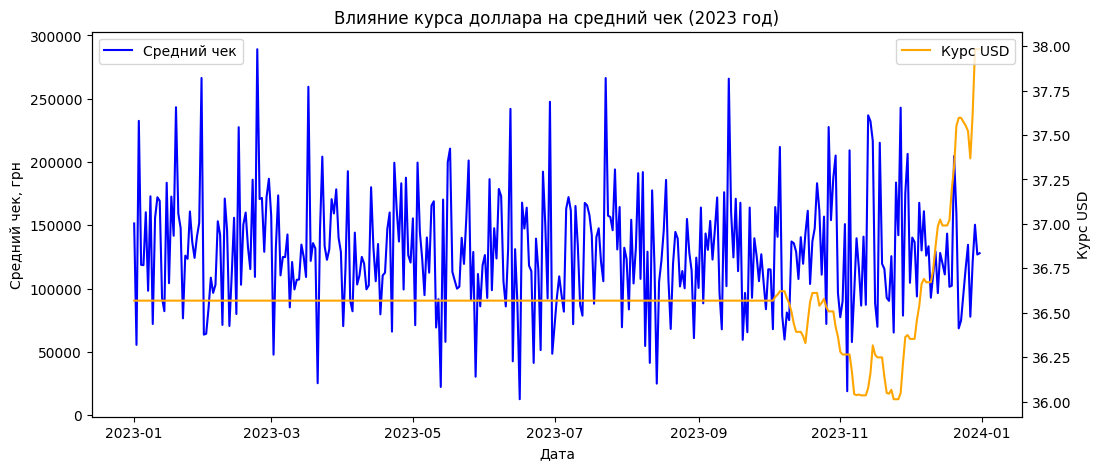

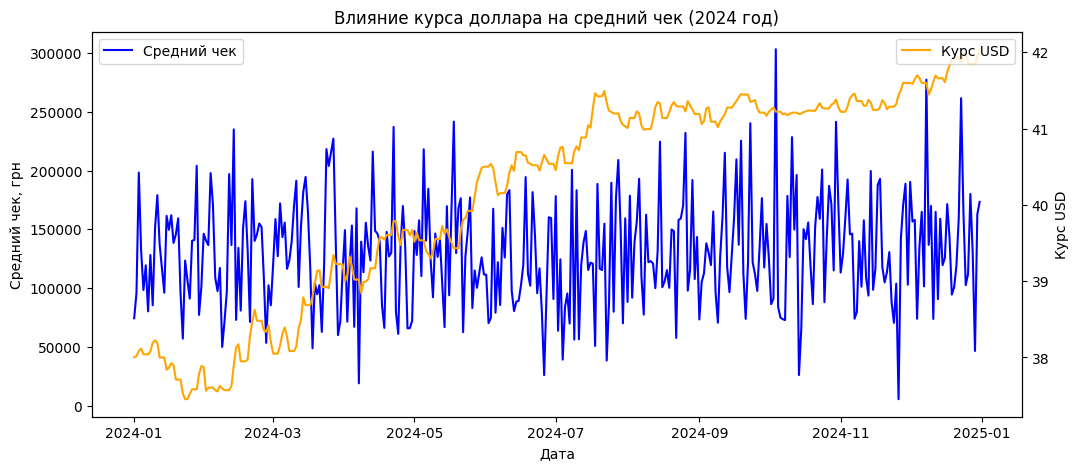

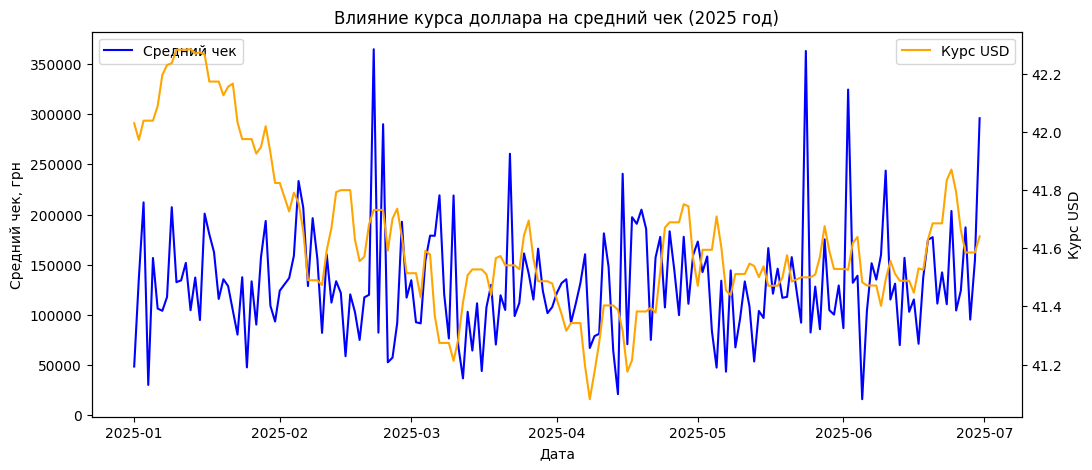

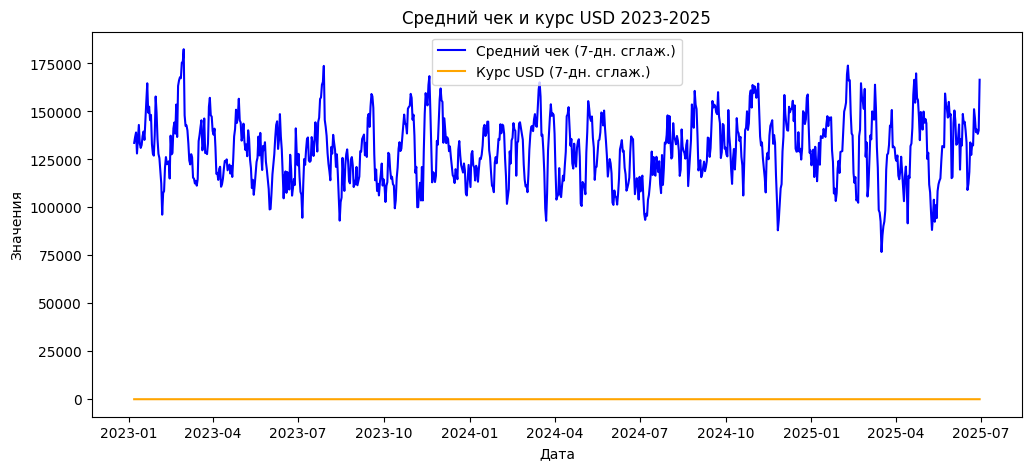

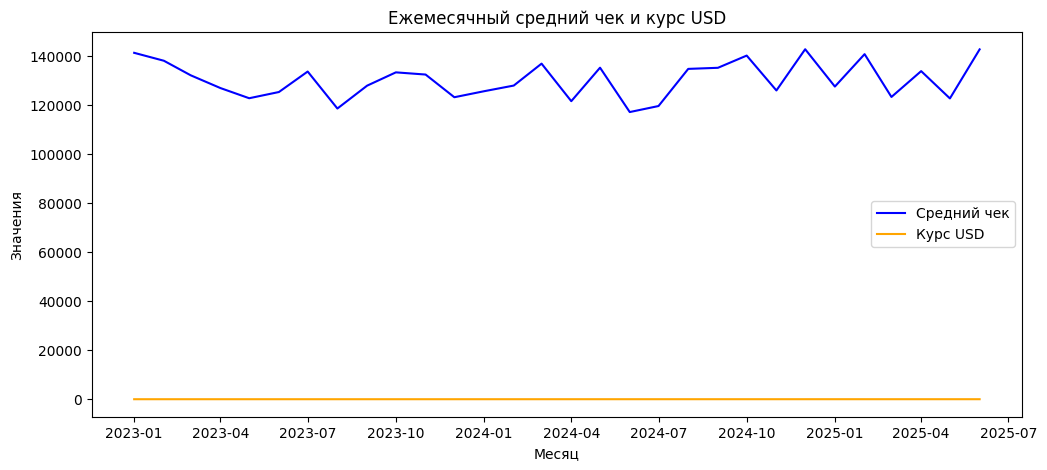

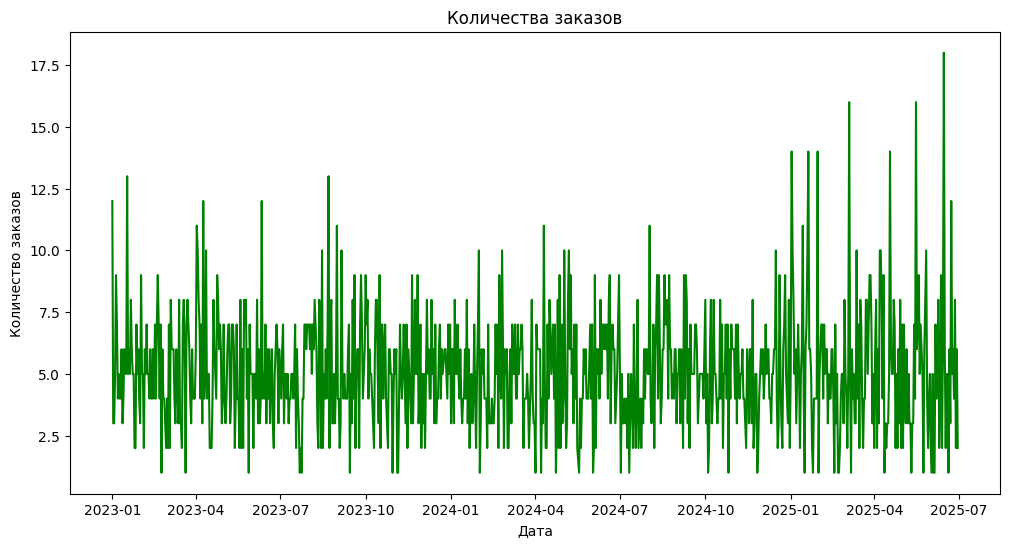

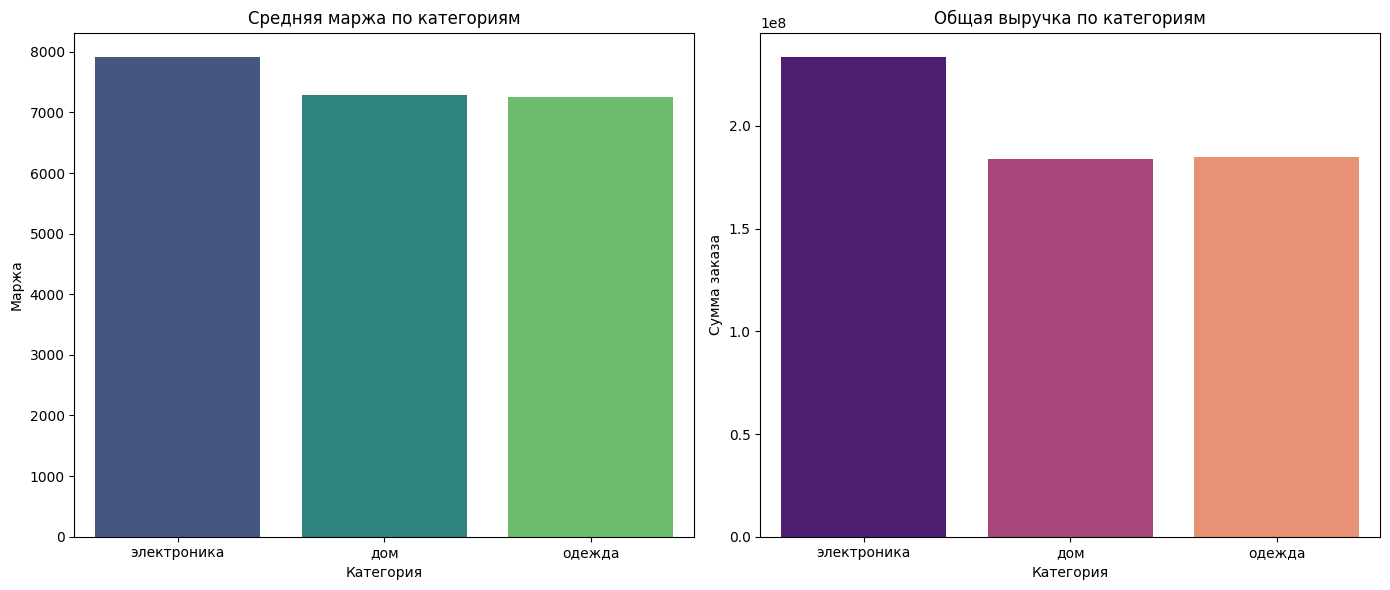

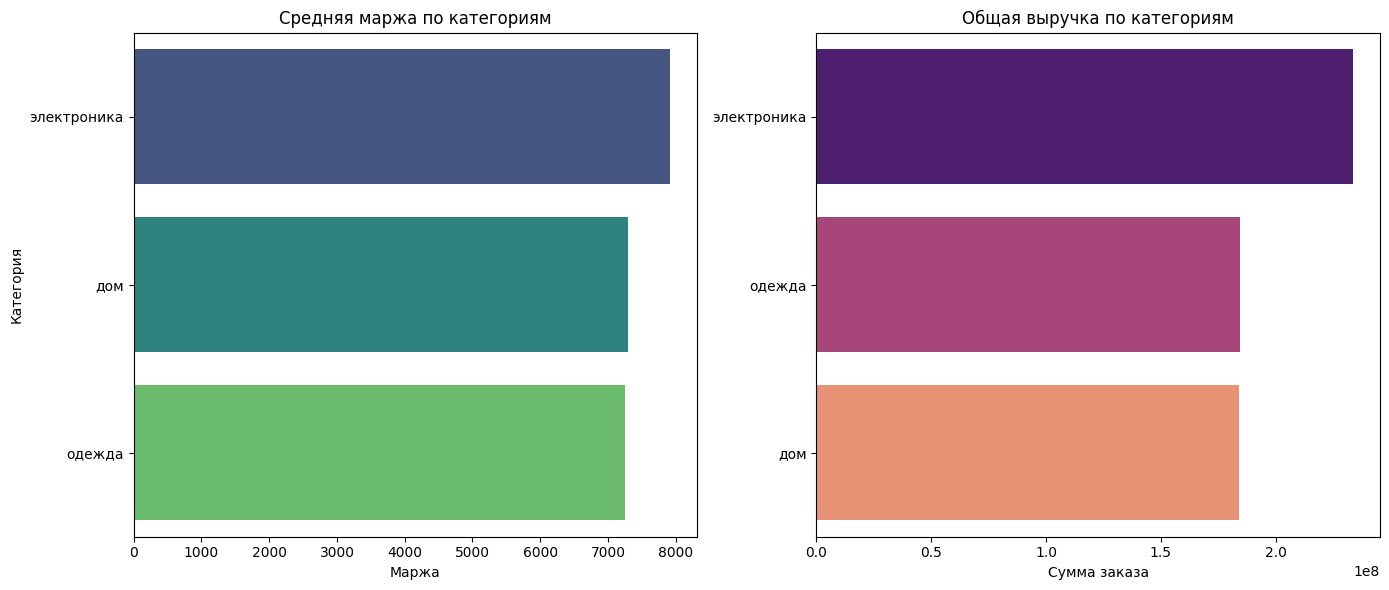

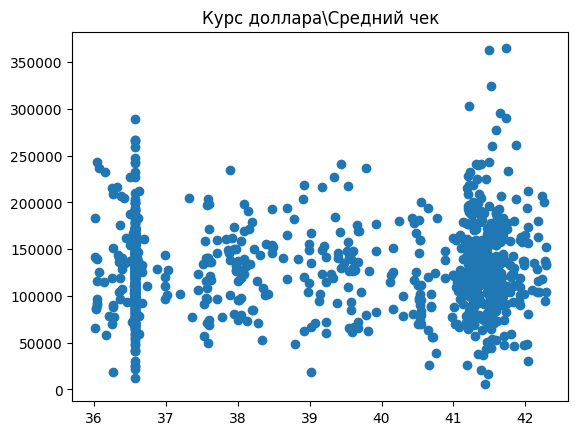

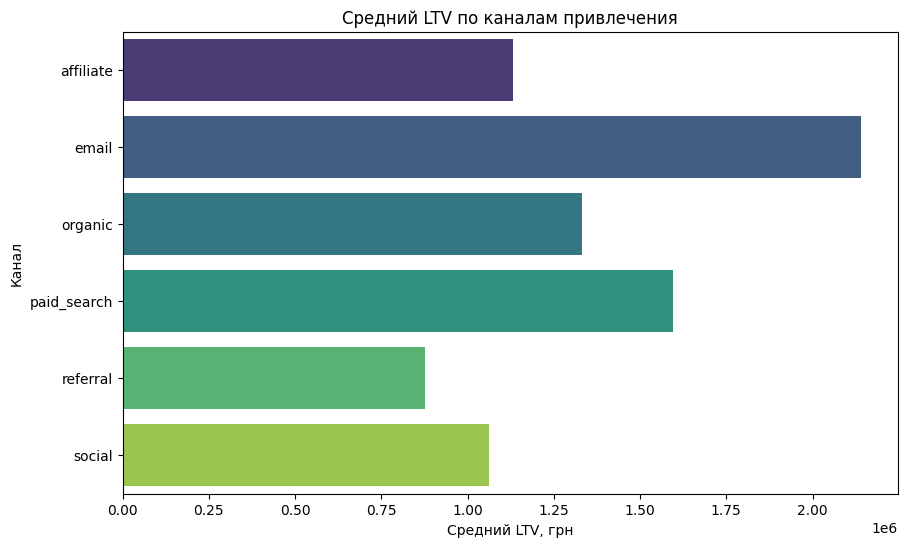

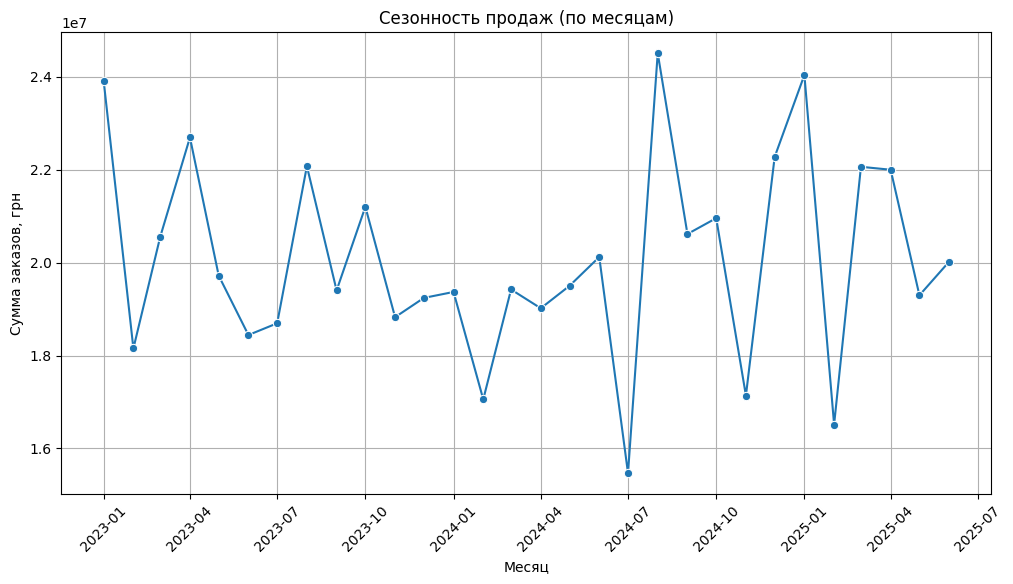

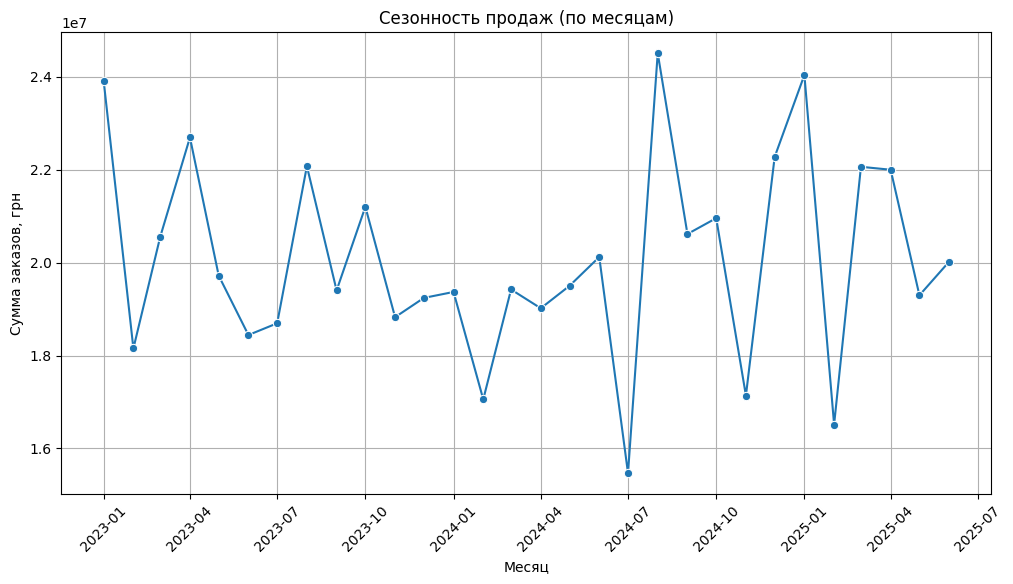

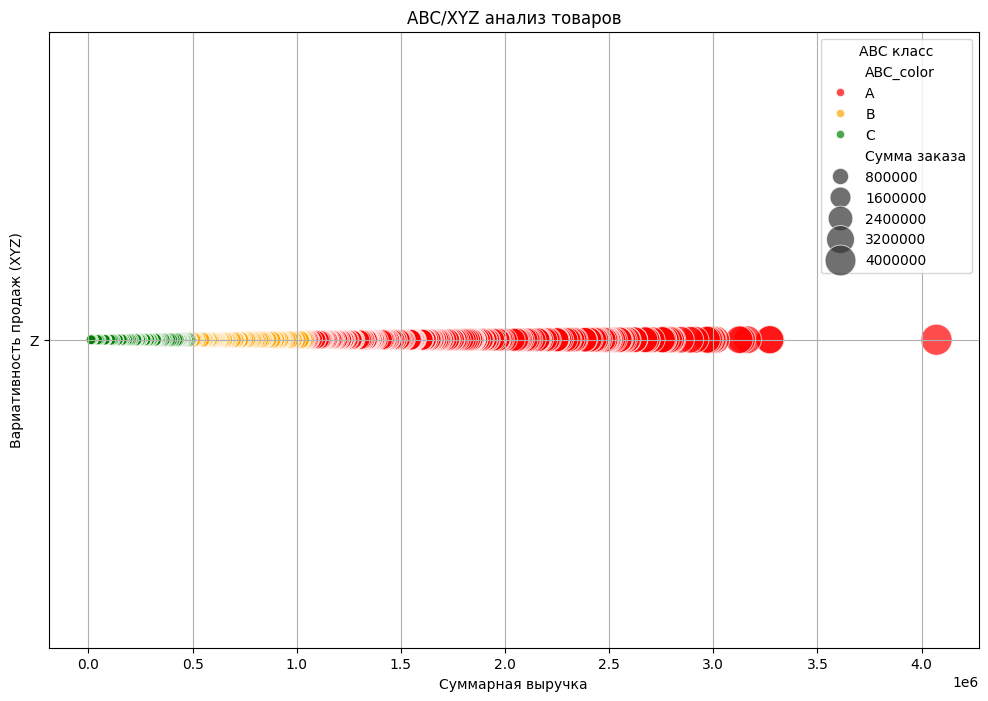

,Блок,Вывод
0,Сезонность продаж,"Пик продаж в August 2024, минимум — July 2024"
1,Влияние курса доллара на средний чек и заказы,"Корреляция USD со средним чеком: 0.02, с количеством заказов: 0.01"
2,"Категории с высокой маржой, но низкими продажами","электроника, дом"
3,Каналы привлечения с высоким LTV,"email, paid_search, organic"
4,Топ клиентов (для лояльности),"382, 85, 181, 205, 73, 432, 94, 313, 416, 415"
5,Средние показатели,"Средний чек: 65859.51, Средняя маржа: 7517.57, Средняя частота покупок на клиента: 20.32, Средний LTV клиента: 1338411.64"
6,ABC-анализ категорий,"A — дом, одежда (61.2% выручки), топ товары: tefal зеркало 8789e; B — (0.0% выручки), топ товары: ; C — электроника (38.8% выручки), топ товары: lenovo умная колонка 4011e"
7,XYZ-анализ категорий,"X — (CV=0.00, Стабильные); Y — дом, одежда, электроника (CV=0.14, Средняя стабильность); Z — (CV=0.00, Стабильные)"
8,Лучшие бренды по продажам,"xiaomi, luminarc, canon"
9,Худшие бренды по продажам,"sony, nike, puma"


In [374]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

monthly_sales = orders_products.groupby(orders_products['Дата заказа'].dt.to_period('M'))['Сумма заказа'].sum().reset_index()
monthly_sales['Дата заказа'] = monthly_sales['Дата заказа'].dt.to_timestamp()
peak_month = monthly_sales.loc[monthly_sales['Сумма заказа'].idxmax(), 'Дата заказа']
low_month = monthly_sales.loc[monthly_sales['Сумма заказа'].idxmin(), 'Дата заказа']

corr_avg_check = orders_vs_usd['avg_check'].corr(orders_vs_usd['usd_rate'])
corr_orders = orders_vs_usd['ID заказа'].corr(orders_vs_usd['usd_rate'])

category_margin = orders_products.groupby('Категория', as_index=False).agg({'Маржа':'mean', 'Сумма заказа':'sum'})
high_margin_low_sales = category_margin.sort_values(['Маржа','Сумма заказа'], ascending=[False, True]).head(2)

orders_with_channel = orders_products.merge(sessions[['customer_id','channel']], on='customer_id', how='left')
channels = orders_with_channel.groupby('channel', as_index=False).agg({'customer_id':'nunique','Сумма заказа':'sum'})
channels['Средний LTV'] = channels['Сумма заказа']/channels['customer_id']
top_channels = channels.sort_values('Средний LTV', ascending=False).head(3)

top_clients = rfm.sort_values('Monetary', ascending=False).head(10)

category_sales = orders_products.groupby('Категория', as_index=False)['Сумма заказа'].sum()
category_sales['Доля,%'] = 100*category_sales['Сумма заказа']/category_sales['Сумма заказа'].sum()
category_sales['Накопительно,%'] = category_sales['Доля,%'].cumsum()
category_sales['ABC'] = category_sales['Накопительно,%'].apply(lambda x: 'A' if x<=80 else 'B' if x<=95 else 'C')

monthly_cat = orders_products.groupby(['Категория', orders_products['Дата заказа'].dt.to_period('M')])['Сумма заказа'].sum().reset_index()
abc_groups = category_sales.groupby('ABC')['Категория'].apply(list).to_dict()
abc_share = category_sales.groupby('ABC')['Сумма заказа'].sum() / category_sales['Сумма заказа'].sum() * 100

abc_summary = []
for group in ['A','B','C']:
    cats = ', '.join(abc_groups.get(group, []))
    share = abc_share.get(group, 0)
    top_products_in_group = top_products_abc[top_products_abc['ABC']==group].head(1)
    top_products_names = ', '.join(top_products_in_group['Название товара'].tolist())
    abc_summary.append(f"{group} — {cats} ({share:.1f}% выручки), топ товары: {top_products_names}")

xyz_groups = abcxyz.groupby('XYZ')['Категория'].apply(list).to_dict()
xyz_cv = abcxyz.groupby('XYZ')['CV'].mean()
xyz_summary = []
for group in ['X','Y','Z']:
    cats = ', '.join(xyz_groups.get(group, []))
    cv = xyz_cv.get(group, 0)
    stability = 'Стабильные' if cv < 0.1 else 'Средняя стабильность' if cv < 0.25 else 'Нестабильные'
    xyz_summary.append(f"{group} — {cats} (CV={cv:.2f}, {stability})")

best_products_list = ', '.join(top_products_abc.head(5).apply(
    lambda x: f"{x['Название товара']} (категория {x['Категория']}, ABC {x['ABC']})", axis=1))
worst_products_list = ', '.join(top_products_abc.tail(5).apply(
    lambda x: f"{x['Название товара']} (категория {x['Категория']}, ABC {x['ABC']})", axis=1))

top_brands_list = ', '.join(top_brands.head(3)['Бренд'].tolist())
worst_brands_list = ', '.join(top_brands.tail(3)['Бренд'].tolist())

show_all_plots()

ceo_dashboard = pd.DataFrame({
    'Блок': [
        'Сезонность продаж',
        'Влияние курса доллара на средний чек и заказы',
        'Категории с высокой маржой, но низкими продажами',
        'Каналы привлечения с высоким LTV',
        'Топ клиентов (для лояльности)',
        'Средние показатели',
        'ABC-анализ категорий',
        'XYZ-анализ категорий',
        'Лучшие бренды по продажам',
        'Худшие бренды по продажам',
        'Лучшие товары',
        'Худшие товары'
    ],
    'Вывод': [
        f'Пик продаж в {peak_month.strftime("%B %Y")}, минимум — {low_month.strftime("%B %Y")}',
        f'Корреляция USD со средним чеком: {corr_avg_check:.2f}, с количеством заказов: {corr_orders:.2f}',
        ', '.join(high_margin_low_sales['Категория'].tolist()),
        ', '.join(top_channels['channel'].tolist()),
        ', '.join(top_clients['customer_id'].astype(str).tolist()),
        f"Средний чек: {orders_products['Сумма заказа'].mean():.2f}, "
        f"Средняя маржа: {orders_products['Маржа'].mean():.2f}, "
        f"Средняя частота покупок на клиента: {rfm['Frequency'].mean():.2f}, "
        f"Средний LTV клиента: {rfm['Monetary'].mean():.2f}",
           '; '.join(abc_summary),
        '; '.join(xyz_summary),
        top_brands_list,
        worst_brands_list,
        best_products_list,
        worst_products_list
    ]
})
ceo_dashboard